In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [3]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [4]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [5]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

In [6]:
subject_name = 'SubjectA'
data, labels = retrieve_data(subject_name)

In [7]:
strat_kfold = StratifiedKFold(n_splits = 10)

In [8]:
def create_cnn(input_shape, optimizer = None):
    conv1_init = tf.keras.initializers.GlorotUniform(42)
    conv2_init = tf.keras.initializers.GlorotUniform(42)
    dense1_init = tf.keras.initializers.GlorotUniform(24)
    dense2_init = tf.keras.initializers.GlorotUniform(24)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                               activation = 'relu', kernel_initializer = conv1_init),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = 'relu',
                               kernel_initializer = conv2_init),
        tf.keras.layers.AveragePooling2D(pool_size = (1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = dense1_init),
        tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
    ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [9]:
acc_scores = []
precisions, recalls = [], []
# std_devs = [0.5, 0.6]
n_classes = len(np.unique(labels))
for train_index, test_index in strat_kfold.split(data, labels):
    ## Split data based on the indices determined by StratifiedKFold
    train_data, test_data = data[train_index], data[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    
    ## Noise addition
#     copy_data = train_data.copy()
#     train_data, train_labels = list(train_data), list(train_labels)
#     for index, data in enumerate(copy_data):
#         for dev in std_devs:
#             train_data.append(add_noise(data, std_dev = dev))
#             train_labels.append(train_labels[index])
#     train_data, train_labels = np.array(train_data), np.array(train_labels)
#     print('Train data after noise addition: {}'.format(train_data.shape))
    
    ## Transform data before training
#     train_data = tf.expand_dims(train_data, axis = -1)
#     test_data = tf.expand_dims(test_data, axis = -1)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = n_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = n_classes)
    print('Train data shape: {}'.format(train_data.shape))
    print('Test data shape: {}'.format(test_data.shape))
    input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
    
    ## Start training
    n_epochs = 25
    model = create_cnn(input_shape = input_shape)
    history = model.fit(train_data, train_labels, batch_size = 16, validation_data = (test_data, test_labels),
                        epochs = n_epochs)
    
    ## Make predictions and assess model performance
    predictions = model.predict(test_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    real_label = np.array([np.argmax(label) for label in test_labels])
    _, acc = model.evaluate(test_data, test_labels)
    acc_scores.append(acc)
    precisions.append(precision_score(real_label, predictions, average = 'weighted'))
    recalls.append(recall_score(real_label, predictions, average = 'weighted'))

Train data shape: (1642, 21, 170, 1)
Test data shape: (183, 21, 170, 1)
Epoch 1/25
103/103 [==============================] - 4s 36ms/step - loss: 1.6604 - accuracy: 0.2503 - val_loss: 1.5117 - val_accuracy: 0.3497
Epoch 2/25
103/103 [==============================] - 3s 33ms/step - loss: 1.4615 - accuracy: 0.3709 - val_loss: 1.4049 - val_accuracy: 0.4098
Epoch 3/25
103/103 [==============================] - 4s 34ms/step - loss: 1.3698 - accuracy: 0.4312 - val_loss: 1.3946 - val_accuracy: 0.4645
Epoch 4/25
103/103 [==============================] - 4s 36ms/step - loss: 1.3012 - accuracy: 0.4689 - val_loss: 1.3777 - val_accuracy: 0.4426
Epoch 5/25
103/103 [==============================] - 4s 40ms/step - loss: 1.2358 - accuracy: 0.5177 - val_loss: 1.3404 - val_accuracy: 0.4699
Epoch 6/25
103/103 [==============================] - 4s 38ms/step - loss: 1.1591 - accuracy: 0.5548 - val_loss: 1.4250 - val_accuracy: 0.4153
Epoch 7/25
103/103 [==============================] - 4s 39ms/step - l

103/103 [==============================] - 5s 45ms/step - loss: 1.2540 - accuracy: 0.5006 - val_loss: 1.1045 - val_accuracy: 0.5902
Epoch 6/25
103/103 [==============================] - 5s 44ms/step - loss: 1.1784 - accuracy: 0.5518 - val_loss: 1.0872 - val_accuracy: 0.5956
Epoch 7/25
103/103 [==============================] - 5s 45ms/step - loss: 1.1147 - accuracy: 0.5713 - val_loss: 1.0564 - val_accuracy: 0.6011
Epoch 8/25
103/103 [==============================] - 5s 44ms/step - loss: 1.0423 - accuracy: 0.6169 - val_loss: 1.0318 - val_accuracy: 0.5738
Epoch 9/25
103/103 [==============================] - 5s 45ms/step - loss: 0.9804 - accuracy: 0.6516 - val_loss: 1.0779 - val_accuracy: 0.5628
Epoch 10/25
103/103 [==============================] - 4s 43ms/step - loss: 0.9207 - accuracy: 0.6857 - val_loss: 1.0520 - val_accuracy: 0.6066
Epoch 11/25
103/103 [==============================] - 5s 44ms/step - loss: 0.8566 - accuracy: 0.7046 - val_loss: 1.0678 - val_accuracy: 0.5683
Epoch 12

103/103 [==============================] - 5s 47ms/step - loss: 0.9769 - accuracy: 0.6468 - val_loss: 1.1907 - val_accuracy: 0.5246
Epoch 10/25
103/103 [==============================] - 5s 53ms/step - loss: 0.9164 - accuracy: 0.6967 - val_loss: 1.1532 - val_accuracy: 0.5519
Epoch 11/25
103/103 [==============================] - 5s 53ms/step - loss: 0.8518 - accuracy: 0.7119 - val_loss: 1.2348 - val_accuracy: 0.5246
Epoch 12/25
103/103 [==============================] - 5s 48ms/step - loss: 0.7931 - accuracy: 0.7454 - val_loss: 1.2359 - val_accuracy: 0.5082
Epoch 13/25
103/103 [==============================] - 5s 48ms/step - loss: 0.7345 - accuracy: 0.7631 - val_loss: 1.2446 - val_accuracy: 0.5246
Epoch 14/25
103/103 [==============================] - 5s 44ms/step - loss: 0.6691 - accuracy: 0.8045 - val_loss: 1.2573 - val_accuracy: 0.5355
Epoch 15/25
103/103 [==============================] - 4s 43ms/step - loss: 0.6287 - accuracy: 0.8130 - val_loss: 1.2673 - val_accuracy: 0.5137
Epoc

Epoch 14/25
103/103 [==============================] - 5s 53ms/step - loss: 0.6044 - accuracy: 0.8180 - val_loss: 2.3319 - val_accuracy: 0.2308
Epoch 15/25
103/103 [==============================] - 5s 52ms/step - loss: 0.5527 - accuracy: 0.8375 - val_loss: 2.4012 - val_accuracy: 0.1868
Epoch 16/25
103/103 [==============================] - 5s 52ms/step - loss: 0.4948 - accuracy: 0.8752 - val_loss: 2.4645 - val_accuracy: 0.1978
Epoch 17/25
103/103 [==============================] - 5s 53ms/step - loss: 0.4494 - accuracy: 0.8886 - val_loss: 2.5329 - val_accuracy: 0.2033
Epoch 18/25
103/103 [==============================] - 5s 51ms/step - loss: 0.4123 - accuracy: 0.8996 - val_loss: 2.6312 - val_accuracy: 0.1758
Epoch 19/25
103/103 [==============================] - 5s 51ms/step - loss: 0.3690 - accuracy: 0.9209 - val_loss: 2.6283 - val_accuracy: 0.1978
Epoch 20/25
103/103 [==============================] - 6s 56ms/step - loss: 0.3334 - accuracy: 0.9367 - val_loss: 2.7710 - val_accuracy:

Epoch 19/25
103/103 [==============================] - 6s 55ms/step - loss: 0.3413 - accuracy: 0.9349 - val_loss: 2.8214 - val_accuracy: 0.1703
Epoch 20/25
103/103 [==============================] - 6s 58ms/step - loss: 0.3092 - accuracy: 0.9458 - val_loss: 2.9123 - val_accuracy: 0.1648
Epoch 21/25
103/103 [==============================] - 7s 63ms/step - loss: 0.2623 - accuracy: 0.9677 - val_loss: 3.0406 - val_accuracy: 0.1978
Epoch 22/25
103/103 [==============================] - 7s 65ms/step - loss: 0.2351 - accuracy: 0.9726 - val_loss: 3.0744 - val_accuracy: 0.1538
Epoch 23/25
103/103 [==============================] - 6s 62ms/step - loss: 0.2089 - accuracy: 0.9836 - val_loss: 3.2989 - val_accuracy: 0.2088
Epoch 24/25
103/103 [==============================] - 6s 59ms/step - loss: 0.1811 - accuracy: 0.9854 - val_loss: 3.3928 - val_accuracy: 0.1868
Epoch 25/25
6/6 [==============================] - 0s 27ms/step - loss: 3.4367 - accuracy: 0.1813
Train data shape: (1643, 21, 170, 1)
T

In [10]:
df = pd.DataFrame({'Accuracy': acc_scores, 'Precision': precisions, 'Recall': recalls})
df.to_csv('Hasil/{}_no_augment.csv'.format(subject_name))
df

,Accuracy,Precision,Recall
0,0.420765,0.428145,0.420765
1,0.420765,0.407866,0.420765
2,0.551913,0.546724,0.551913
3,0.459016,0.470881,0.459016
4,0.469945,0.487592,0.469945
5,0.335165,0.342683,0.335165
6,0.214286,0.203914,0.214286
7,0.241758,0.234566,0.241758
8,0.181319,0.176438,0.181319
9,0.214286,0.223984,0.214286


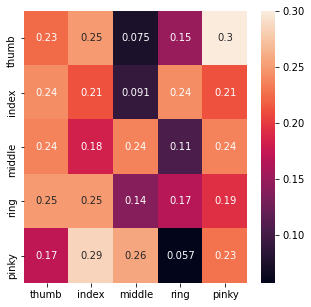

In [11]:
label = ['thumb', 'index', 'middle', 'ring', 'pinky']
cm = confusion_matrix(real_label, predictions, normalize = 'true')
df_cm = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot = True)
plt.savefig('Hasil/CM_{}_no_augment.png'.format(subject_name), facecolor = 'w', edgecolor = 'w')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Hasil/No Augment.png')
plt.grid(True)
plt.show()